In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%config InlineBackend.figure_formats = ['svg']

In [3]:
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['FreeSans']

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import pickle
import copy
import itertools
from tqdm import tqdm
from joblib import Parallel, delayed
import mdptoolbox.mdp as mdptools

In [5]:
# Ground truth MDP model
MDP_parameters = joblib.load('../data/MDP_parameters.joblib')
P = MDP_parameters['transition_matrix_absorbing'] # (A, S, S_next)
R = MDP_parameters['reward_matrix_absorbing_SA'] # (S, A)
nS, nA = R.shape
gamma = 0.99

In [6]:
# unif rand isd, mixture of diabetic state
PROB_DIAB = 0.2
isd = joblib.load('../data/modified_prior_initial_state_absorbing.joblib')
isd = (isd > 0).astype(float)
isd[:720] = isd[:720] / isd[:720].sum() * (1-PROB_DIAB)
isd[720:] = isd[720:] / isd[720:].sum() * (PROB_DIAB)

In [7]:
nS, nA

(1442, 8)

## Helper functions

In [8]:
# Map back to the policy in discrete MDP
def convert_to_policy_table(pi):
    pol = np.zeros((nS, nA))
    pol[list(np.arange(nS-2)), pi[:-2]] = 1
    pol[-2:, 0] = 1
    return pol

In [9]:
def policy_eval_analytic(P, R, pi, gamma):
    """
    Given the MDP model (transition probability P (S,A,S) and reward function R (S,A)),
    Compute the value function of a policy using matrix inversion
    
        V_π = (I - γ P_π)^-1 R_π
    """
    nS, nA = R.shape
    R_pi = np.sum(R * pi, axis=1)
    P_pi = np.sum(P * np.expand_dims(pi, 2), axis=1)
    V_pi = np.linalg.inv(np.eye(nS) - gamma * P_pi) @ R_pi
    return V_pi

In [10]:
# For plotting
def conv_to_np(this_list):
    this_arr = np.array(this_list)[:, np.newaxis]
    # Make this idempotent
    this_arr = this_arr.squeeze()[:, np.newaxis]
    return this_arr

def simulator_eval_on_policy(π):
    NSTEPS = 100
    PROB_DIAB = 0.2
    DISCOUNT = 0.99
    USE_BOOSTRAP=True
    N_BOOTSTRAP = 100
    
    # Get the true RL reward as a sanity check
    # Note that the RL policy includes actions for "death" and "discharge" absorbing states, which we ignore by taking [:-2, :]
    from sepsisSimDiabetes.DataGenerator import DataGenerator
    import cf.counterfactual as cf
    import cf.utils as utils
    
    np.random.seed(90000)
    dgen = DataGenerator()
    NSIMSAMPS_RL = 1000
    states_full_rl, actions_full_rl, lengths_full_rl, rewards_full_rl, diab_full_rl, _, _ = dgen.simulate(
       NSIMSAMPS_RL, NSTEPS, policy=π[:-2, :], policy_idx_type='full', 
       p_diabetes=PROB_DIAB, modified=True, use_tqdm=False) #True, tqdm_desc='RL Policy Simulation')

    obs_samps_full_rlpol = utils.format_dgen_samps(
       states_full_rl, actions_full_rl, rewards_full_rl, diab_full_rl, NSTEPS, NSIMSAMPS_RL)

    this_true_full_rl_reward = cf.eval_on_policy(
        obs_samps_full_rlpol, discount=DISCOUNT, 
        bootstrap=USE_BOOSTRAP, n_bootstrap=N_BOOTSTRAP)  # Need a second axis to concat later
    
    return conv_to_np([this_true_full_rl_reward])

## Planning

### Policy Iteration

In [11]:
PI = mdptools.PolicyIteration(P, R, discount=gamma)
PI.run()
V_star_PI = np.array(PI.V)
π_star_PI = np.array(PI.policy)

### Value Iteration

In [12]:
VI = mdptools.ValueIteration(P, R, discount=gamma, epsilon=1e-10)
VI.run()
V_star_VI = np.array(VI.V)
π_star_VI = np.array(VI.policy)

# re-evalute the learned policy
pi_star_VI = convert_to_policy_table(π_star_VI)
V_π_star_PE = policy_eval_analytic(P.transpose((1,0,2)), R, pi_star_VI, gamma)

### Plot and save

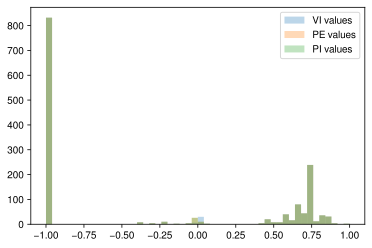

In [13]:
plt.hist(V_star_VI, bins=50, alpha=0.3, label='VI values')
plt.hist(V_π_star_PE, bins=50, alpha=0.3, label='PE values')
plt.hist(V_star_PI, bins=50, alpha=0.3, label='PI values')
plt.legend()
plt.show()

In [14]:
isd @ V_star_PI

0.6775418119368786

In [15]:
np.all(π_star_VI == π_star_PI)

True

In [16]:
joblib.dump(π_star_PI, '../data/π_star_PI.joblib')
joblib.dump(V_star_PI, '../data/V_star_PI.joblib')

joblib.dump(π_star_VI, '../data/π_star_VI.joblib')
joblib.dump(V_star_VI, '../data/V_star_VI.joblib')
joblib.dump(V_π_star_PE, '../data/V_π_star_PE.joblib')

joblib.dump(pi_star_VI, '../data/π_star.joblib')

['../data/π_star.joblib']

In [17]:
true_rewards_list = [simulator_eval_on_policy(π) for π in [pi_star_VI]]

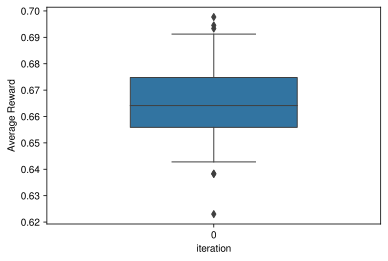

0.6641307574316647


In [18]:
reward_df = pd.DataFrame(np.concatenate(true_rewards_list, axis=1))
sns.boxplot(data=reward_df, whis=[2.5, 97.5], width=0.5, linewidth=1)
plt.ylabel("Average Reward")
plt.xlabel('iteration')
plt.show()
print(reward_df.median().item())